In [82]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)
sns.set(style="darkgrid")

Pandas version: 2.2.2
NumPy version: 1.26.4
Seaborn version: 0.13.2
Matplotlib version: 3.8.4


In [2]:
df = pd.read_csv("loan.csv", low_memory=False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
df.shape

(39717, 111)

## Remove non required columns

In [4]:
# List of columns to be removed for various reasons
to_be_removed_columns = set()

In [5]:
#  Check for columns which are completely empty or just have one value.
#  We can remove them as they serve very little purpose for our analysis

to_be_removed_columns.update(list(df.columns[df.isna().sum()==len(df)].values))
to_be_removed_columns.update(list(df.columns[df.nunique()==1]))
len(to_be_removed_columns)

63

In [6]:
# Drop non required columns
df1 = df.drop(columns=to_be_removed_columns, axis=1)
df1.shape

# Number of columns have been reduced to 48 now.

(39717, 48)

In [7]:
# Further Analysis of some columns whether they are required or not

# Following are the columns being analysed
# 1. id - unique LC assigned id for loan application
# 2. member_id - unique LC assigned id for borrower
# 3. desc - Loan description provided by the borrower. We can easily drop them
# 4. url - URL for the LC page.
#          eg: https://lendingclub.com/browse/loanDetail.action?loan_id=1077501
#          The link has just id as path parameter in that. No other information to extract or use in analysis. Hence can be dropped.
# 5. zipcode - it is masked information which plays very limited role in analysis
#           eg: 860xx

In [8]:
# Check id and member_id to see if they are unique
print(f"Total loans = {len(df)}\nnumber of unique values:\n{df.id.nunique()=}\n{df.member_id.nunique()=}")

# We can remove these values as they are not required for any analysis

Total loans = 39717
number of unique values:
df.id.nunique()=39717
df.member_id.nunique()=39717


In [9]:
df1 = df1.drop(columns=["id", "member_id", "desc", "url", "zip_code"], axis=1)

In [10]:
df1.shape

(39717, 43)

## Remove non required rows

In [11]:
# Check if there are any empty rows to be removed.
df1[df1.isnull().all(axis=1)].shape

# Since there are no empty rows, we don't have to remove anything.

(0, 43)

## Data Cleaning and Modifications

In [12]:
# int_rate, revol_util needs to be updated as numeric
df1.int_rate = df1.int_rate.apply(lambda x: x.split("%")[0]).astype(float)
df1.revol_util = df1.revol_util.apply(lambda x: x.split("%")[0] if not pd.isna(x) else x).astype(float)

## Categorical Variables

In [13]:
# Exploring categorical columns

# loan_status
# grade
# sub_grade
# emp_title
# home_ownership
# verification_status
# purpose
# title
# addr state

# Columns that can be both categorical and continuous
# term
# emp_length

# Derived columns
# We can derive some columns based on the existing information like 
# loan_amount_bucket,
# annual_income_bucket,
# interest_rate_bucket,
# issue_date_year,
# issue_date_month etc which can be used for both univariate and bivariate analysis

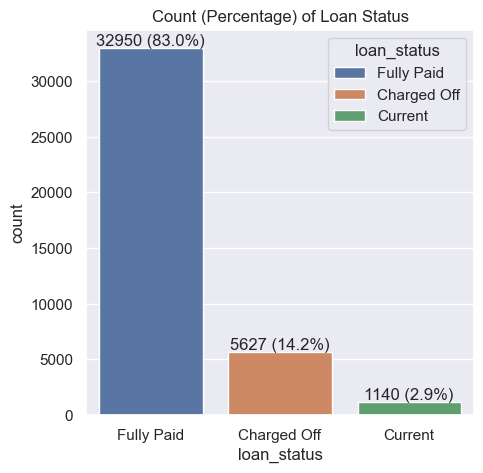

In [14]:
# loan status
fig, ax = plt.subplots(figsize=(5, 5))
plt.title("Count (Percentage) of Loan Status")
ax = sns.countplot(data=df1, x="loan_status", hue="loan_status", legend="full")
ax.tick_params(axis="x")
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/len(df1)*100:0.1f}%)')

# 14.2% of the loans have been defaulted (written off)
# 83% of the loans are fully paid
# 2.9% of the loans are in current status. 

In [15]:
# We dont need current loans for our analysis. 
# Also it constitutes not even 3% of the overall loan profiles. 

loan_status_list = ['Fully Paid','Charged Off']
df1=df1[df1['loan_status'].isin(loan_status_list)]
df1.shape

(38577, 43)

In [16]:
# Univariate Analysis of Term

df1.term.value_counts()

term
36 months    29096
60 months     9481
Name: count, dtype: int64

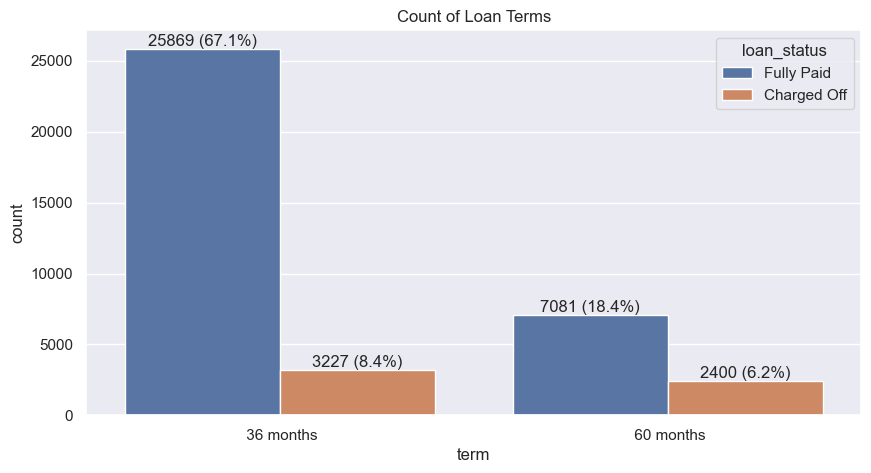

In [17]:
# Bivariate Analysis of Loan Terms vs Loan Status

fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Count of Loan Terms")
sns.countplot(data=df1, x="term", hue="loan_status")
ax.tick_params(axis="x")
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/len(df1)*100:0.1f}%)')

# We have more number of loans belonging to 36 months term and also more number of loans defaulted when term is 36months.
# But it is apparent that loans having 60 months as term has higher default rate.

In [18]:
# Lets find the percentage of loan defaulters based on each term.

term_df=pd.DataFrame(data=round((100*df1[df1.loan_status == "Charged Off"].term.value_counts())/df1.term.value_counts(),2))
term_df.rename(columns={'term':'count'},inplace=True)
term_df.sort_values(by='count',ascending=False,inplace=True)
term_df

# Clearly loans under 60 months category has higher rate of default.

,count
term,
60 months,25.31
36 months,11.09


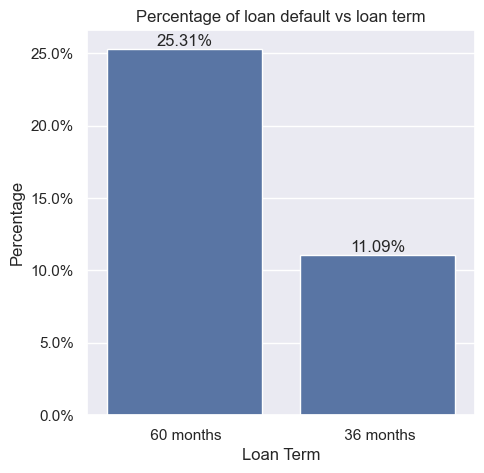

In [19]:
import matplotlib.ticker as mtick
plt.figure(figsize=(5,5))
ax=sns.barplot(x=term_df.index,y='count',data=term_df)
ax.set(xlabel='Loan Term', ylabel='Percentage',title='Percentage of loan default vs loan term')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for c in ax.containers:
    ax.bar_label(c, fmt= lambda x: f"{x}%")
plt.show()

#### Observation - loans belonging to 60 months category has higher rate of default.

In [20]:
# Interest Rate

df1.int_rate.describe()

# Average interest rate is around 12%
# Max interest rate is around 24.4%
# IQR = 9% - 14%

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64

<Axes: title={'center': 'Charged Off Loans'}, xlabel='int_rate', ylabel='Count'>

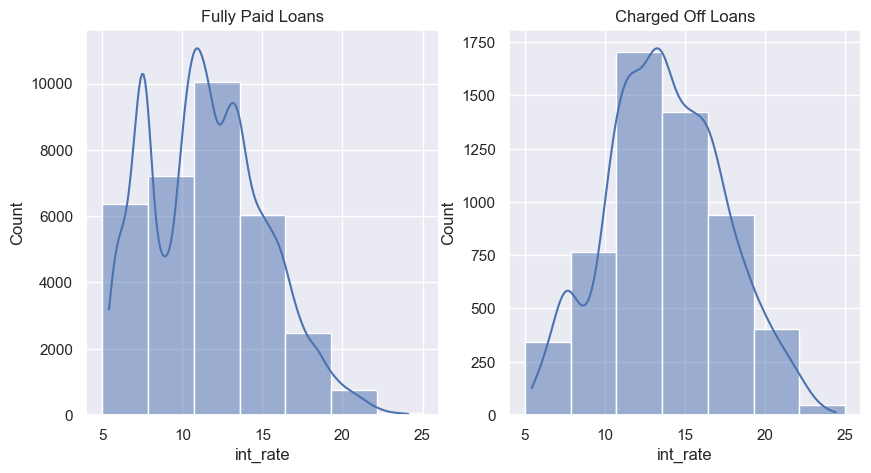

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].set_title("Fully Paid Loans")
axs[1].set_title("Charged Off Loans")
sns.histplot(data=df1[df1.loan_status=="Fully Paid"], x="int_rate", binwidth=3, binrange=(5,25), kde=True, ax=axs[0])
sns.histplot(data=df1[df1.loan_status=="Charged Off"], x="int_rate", binwidth=3, binrange=(5,25), kde=True, ax=axs[1])

# Both Fully Paid and Charged Off Loans have peaks at 11%-14%

In [22]:
# Create a derived bucket column to perform univariate and bivariate analysis

df1["int_rate_buckets"] = pd.cut(df1.int_rate, bins=[5,8,11,14,17,20,25], labels=["5-8", "8-11", "11-14", "14-17", "17-20", "20-25"])
df1.int_rate_buckets.value_counts()

int_rate_buckets
11-14    11596
5-8       8218
8-11      8106
14-17     7101
17-20     2786
20-25      770
Name: count, dtype: int64

In [23]:
# Bivariate Analysis of Interest Rate and Loan Status

ir_loan_status_df = df1.groupby(by=["int_rate_buckets", "loan_status"], observed=True)["loan_amnt"].count().reset_index(name="count")
ir_loan_status_df['pct'] = 100 * ir_loan_status_df['count'] / ir_loan_status_df.groupby(['int_rate_buckets'], observed=True)['count'].transform('sum')

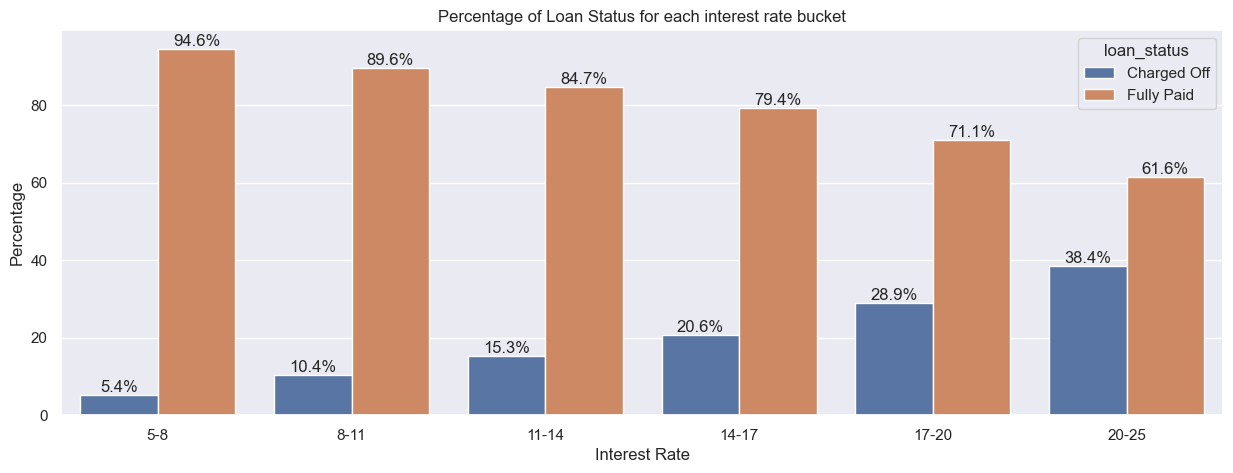

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=ir_loan_status_df, x="int_rate_buckets", hue="loan_status", y="pct", ax=ax)
ax.set(xlabel='Interest Rate', ylabel='Percentage',title='Percentage of Loan Status for each interest rate bucket')
ax.tick_params(axis='y')
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:0.1f}%')

# Higher interest rates have led to relatively more defaults.
# For interest rates between 17-25, nearly 1/3rd of the loans are being defaulted

#### Observation - We can clearly see that higher interest rates have led to relatively more defaults.

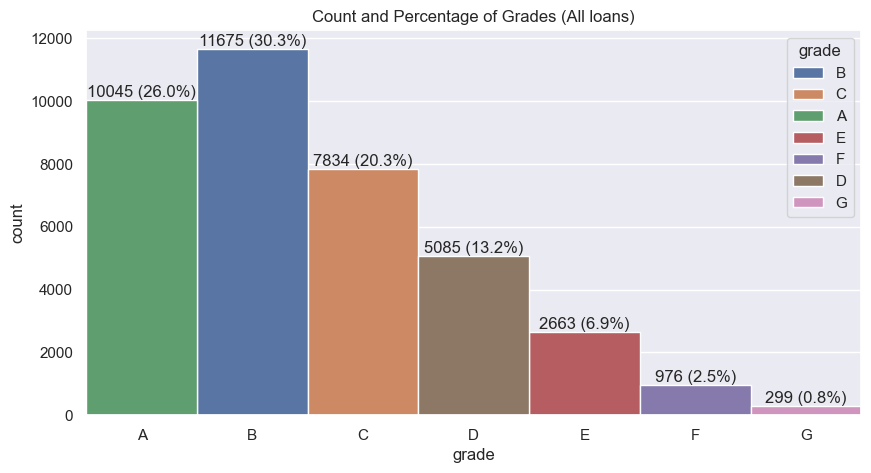

In [25]:
# Grade - Univariate Analysis

# Grade vs Count (All loans)
grade_order = sorted(df1.grade.unique())
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Count and Percentage of Grades (All loans)")
sns.countplot(data=df1, x="grade", hue="grade", legend="full", width=1.0, ax=ax, order=grade_order)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/len(df1)*100:0.1f}%)')
plt.show()

# highest grade B (30.3%) followed by grade A (26)

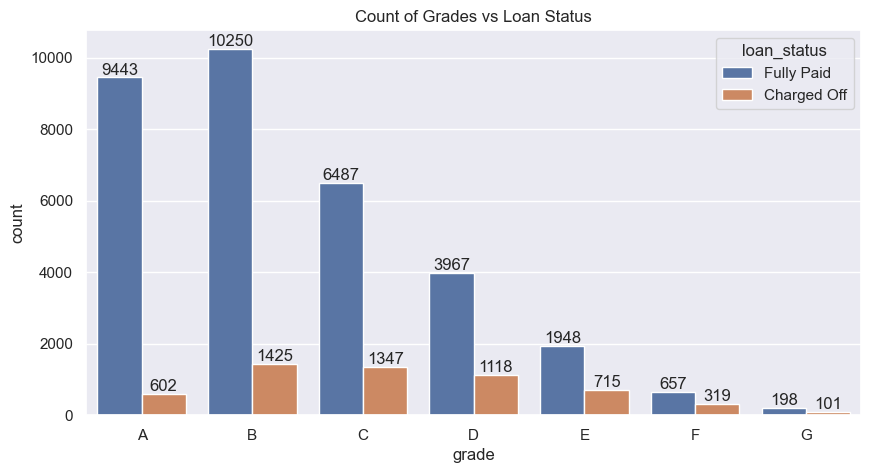

In [26]:
# Bivariate analysis of Grade vs Loan status

grade_order = sorted(df1.grade.unique())
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Count of Grades vs Loan Status")
sns.countplot(data=df1, x="grade", hue="loan_status", order=grade_order)
for c in ax.containers:
    ax.bar_label(c)
plt.show()

In [27]:
#calculate the percentage of loan defaults vs grade
grade_df=pd.DataFrame(data=round((100*df1[df1.loan_status == "Charged Off"].grade.value_counts())/df1.grade.value_counts(),2))
grade_df.rename(columns={'grade':'count'},inplace=True)

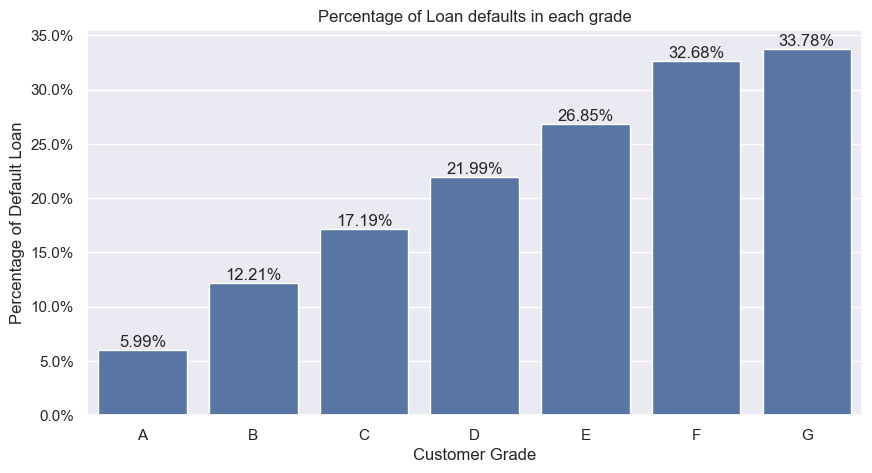

In [28]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x=grade_df.index,y='count',data=grade_df)
ax.set(xlabel='Customer Grade', ylabel='Percentage of Default Loan',title='Percentage of Loan defaults in each grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for c in ax.containers:
    ax.bar_label(c, fmt= lambda x: f"{x}%")
plt.show()

# F and G has more than 30% default rate.

#### Observation - Rate of Default increases from A to G. 

<Axes: title={'center': 'Count of Sub-Grades (All loans)'}, xlabel='sub_grade', ylabel='count'>

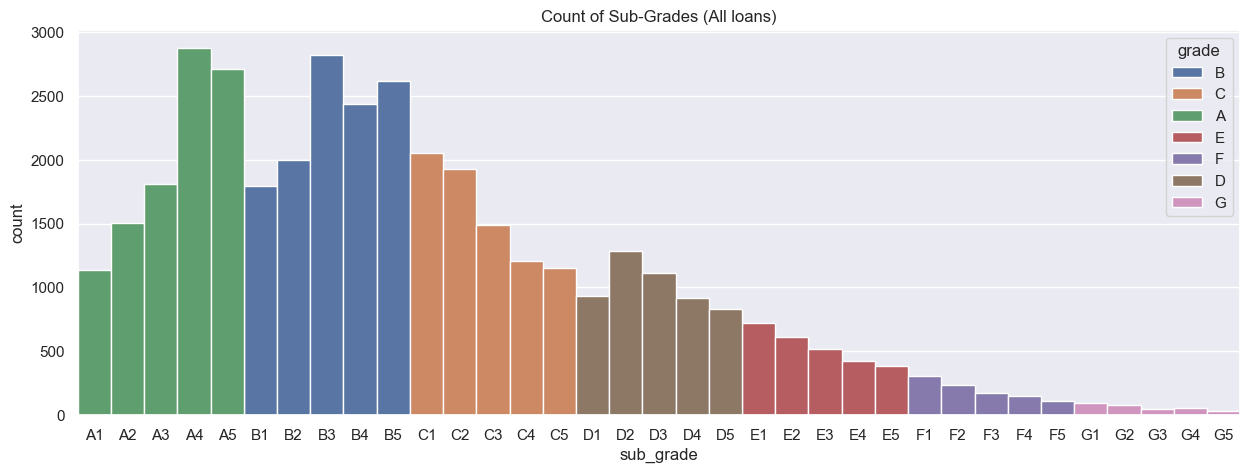

In [29]:
# sub_grade - Univariate Analysis

# sub-grade vs Count (All loans)
sub_grade_order = sorted(df1.sub_grade.unique())
ig, ax = plt.subplots(figsize=(15,5))
plt.title("Count of Sub-Grades (All loans)")
sns.countplot(data=df1, x="sub_grade", hue="grade", legend="full", width=1.0, ax=ax, order=sub_grade_order)

# More loans belong to sub grades A and B.

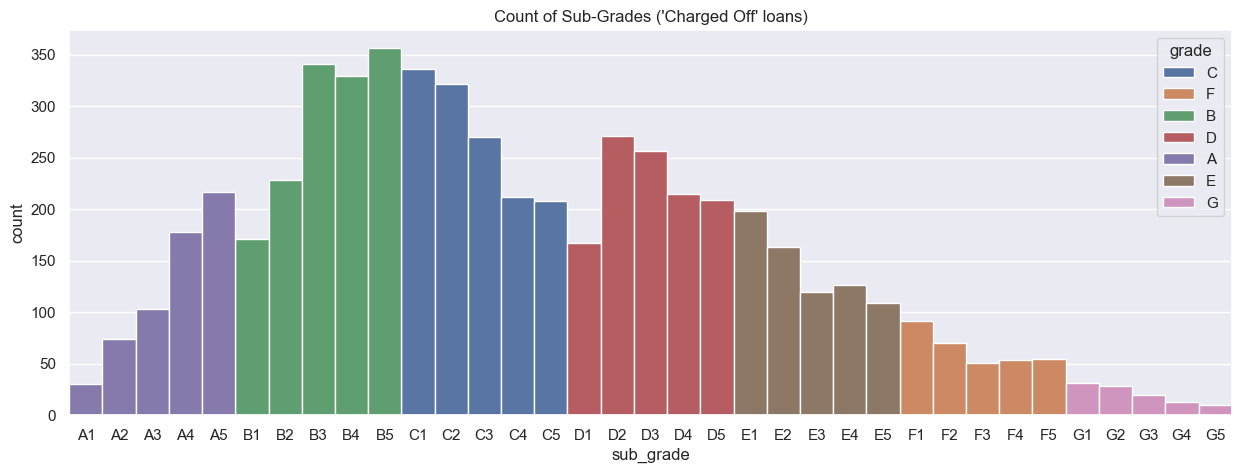

In [30]:
# sub_grade - Bivariate analysis sub-grade vs Loan status

# sub-grade vs Count (Only 'Charged Off' loan applications)
charged_off_sub__grade_order = sorted(df1[df1.loan_status == "Charged Off"].sub_grade.unique())
fig, ax = plt.subplots(figsize=(15, 5))
plt.title("Count of Sub-Grades ('Charged Off' loans)")
sns.countplot(data=df1[df1.loan_status == "Charged Off"], x="sub_grade", hue="grade", legend="full", width=1.0, ax=ax, order=charged_off_sub__grade_order)
plt.show()

# Clearly sub-grades of A have lesser probability of default

In [31]:
# emp_title
# There are some null values both it is not good idea to replace null with any other value.
df1.emp_title.value_counts()

emp_title
US Army                                     131
Bank of America                             107
IBM                                          65
AT&T                                         57
Kaiser Permanente                            56
                                           ... 
amneal pharmaceuticals                        1
Net Equity Financial                          1
Kernersville Fire Department                  1
The Keith Corp. (empl by county, now Kei      1
Evergreen Center                              1
Name: count, Length: 28027, dtype: int64

In [32]:
# This column cannot be used for any analysis. It can be dropped
df1 = df1.drop(columns=["emp_title"], axis=1)

In [33]:
# emp_length

# Clean the data - by removing the ' years' suffix and also updating '<1'to '0' and '10+' to 10 as mentioned in Data Dictionary
df1.emp_length = df1.emp_length.apply(lambda x: x.rstrip(" years") or x.rstrip(" year") or x.rstrip("+ years") if(isinstance(x, str)) else x)
df1.emp_length = df1.emp_length.replace(to_replace=["10+", "< 1"], value=["10", "0"]).astype(float)

df1.emp_length.value_counts()

emp_length
10.0    8488
0.0     4508
2.0     4291
3.0     4012
4.0     3342
5.0     3194
1.0     3169
6.0     2168
7.0     1711
8.0     1435
9.0     1226
Name: count, dtype: int64

In [34]:
print(f"The number of nan cells in emp_length are {df1.emp_length.isna().sum()}")

# To replace the nan cells, lets find the mean, median and mode
print(f"{df1.emp_length.mode().values[0]=},\n{df1.emp_length.mean()=},\n{df1.emp_length.median()=}")

#  Mean = 4.97, Median = 4.0 and Mode = 10

# Observing the value counts above, the Mode value `10` is almost double to the second highest emp_length.
# Updating the nan with Mode doesn't impact the overall scenario
# whereas if we replace nan with either mean or median, then the ranking of emp_length will alter significantly.

# Replace the nan with mode
df1.emp_length = df1.emp_length.fillna(df1.emp_length.mode()[0]).astype(int)
df1.emp_length.value_counts()

The number of nan cells in emp_length are 1033
df1.emp_length.mode().values[0]=10.0,
df1.emp_length.mean()=4.9409759215853395,
df1.emp_length.median()=4.0


emp_length
10    9521
0     4508
2     4291
3     4012
4     3342
5     3194
1     3169
6     2168
7     1711
8     1435
9     1226
Name: count, dtype: int64

In [35]:
# emp_length - Bivariate analysis emp_length vs loan status

#calculate the percentage of loan defaulters according to grade
emp_len_df=pd.DataFrame(data=round((100*df1[df1.loan_status == "Charged Off"].emp_length.value_counts())/df1.emp_length.value_counts(),2))
emp_len_df.rename(columns={'grade':'count'},inplace=True)
emp_len_df.sort_values(by='count',ascending=False,inplace=True)

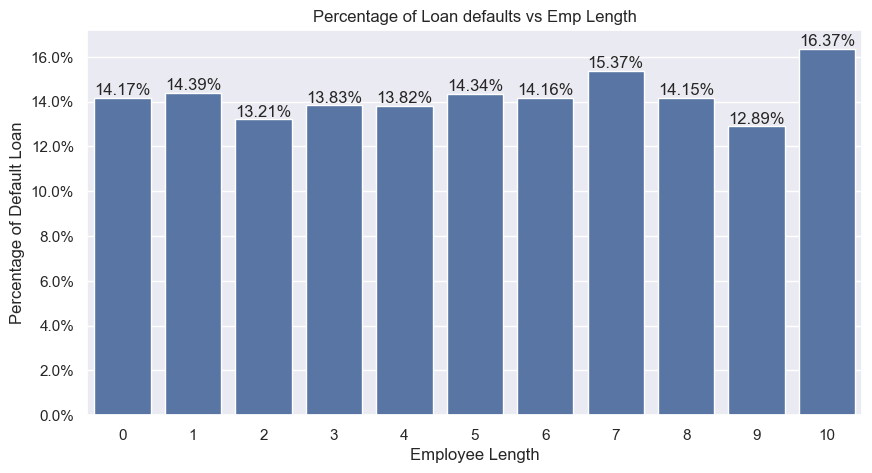

In [36]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x=emp_len_df.index,y='count',data=emp_len_df)
ax.set(xlabel='Employee Length', ylabel='Percentage of Default Loan',title='Percentage of Loan defaults vs Emp Length')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for c in ax.containers:
    ax.bar_label(c, fmt= lambda x: f"{x}%")
plt.show()

# The default rate is higher for employees having 10+ years but it is not very high compared to other categories.

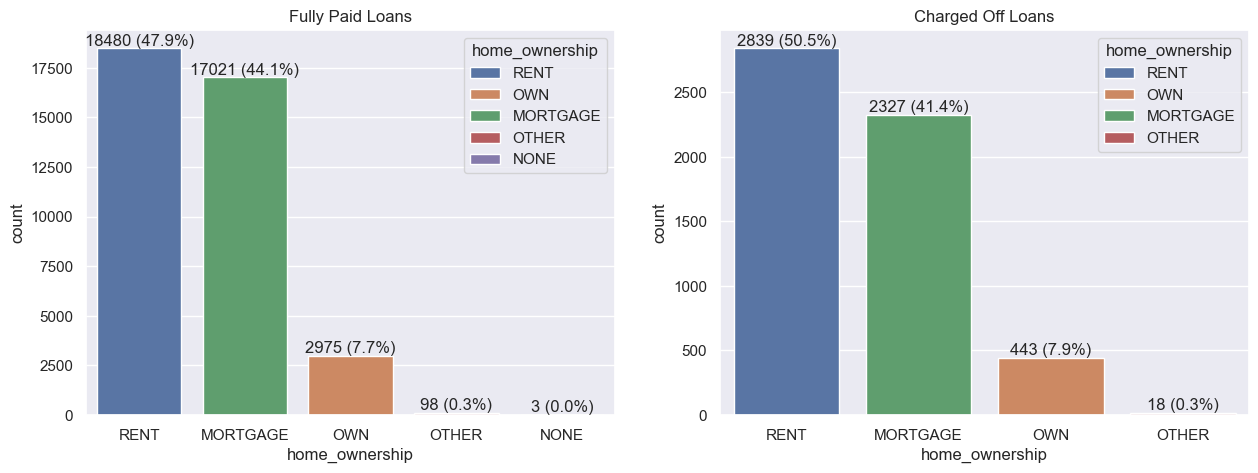

In [37]:
# home_ownership

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].set_title("Fully Paid Loans")
axs[1].set_title("Charged Off Loans")

home_ownership_order = df1.home_ownership.value_counts().index
plt.title("Loan vs Home Ownership - Count and Percentage")
sns.countplot(data=df1, x="home_ownership", hue="home_ownership", legend="full", order=home_ownership_order, ax=axs[0])
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/len(df1)*100:0.1f}%)')

charged_off_home_ownership_order = df1[df1.loan_status == "Charged Off"].home_ownership.value_counts().index
plt.title("Charged Off Loans")
sns.countplot(data=df1[df1.loan_status == "Charged Off"], x="home_ownership", hue="home_ownership", legend="full", order=charged_off_home_ownership_order, ax=axs[1])
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'{x:0.0f} ({x/len(df1[df1.loan_status == "Charged Off"])*100:0.1f}%)')

# RENT and MORTGAGE form the largest home_ownership category and they follow similar pattern in Charged Off loans as well.

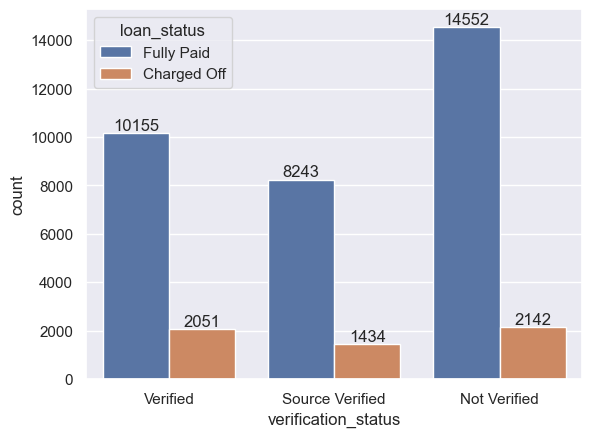

In [38]:
# verification_status

verification_status_order = df1.verification_status.unique()
ax = sns.countplot(data=df1, x="verification_status", hue="loan_status", legend="full", order=verification_status_order)
for c in ax.containers:
    ax.bar_label(c)
plt.show()

In [39]:
verification_status_count = df1.verification_status.value_counts()
default_verification_status_count = df1[df1.loan_status == "Charged Off"].verification_status.value_counts()
print(f"{round((default_verification_status_count / verification_status_count) * 100,2)}")

# Verified and Source Verified have higher default rate compared to Not Verified.
# This is contrary to the common expectation of having higher defaults for non verified category.

verification_status
Not Verified       12.83
Verified           16.80
Source Verified    14.82
Name: count, dtype: float64


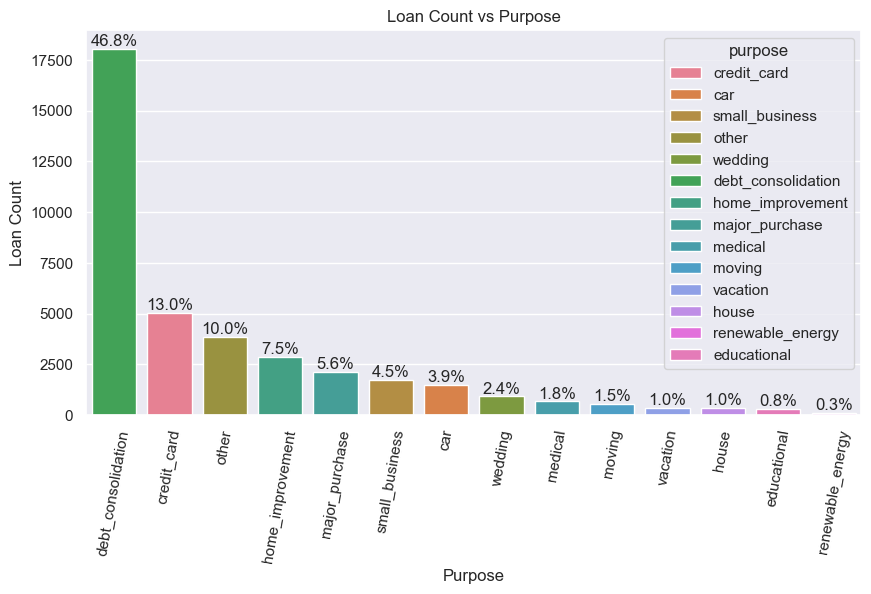

In [40]:
# Purpose - Univariate

purpose_order = df1.purpose.value_counts().index
fig, ax = plt.subplots(figsize=(10, 5))
ax.set(xlabel='Purpose', ylabel='Loan Count',title='Loan Count vs Purpose')
sns.countplot(data=df1, x="purpose", hue="purpose", legend="full", ax=ax, order=purpose_order)
ax.tick_params(axis='x', rotation=80)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x/len(df1)*100:0.1f}%')
plt.show()

# debt_consolidation constitutes the major chunk and it is significantly higher than the second highest category

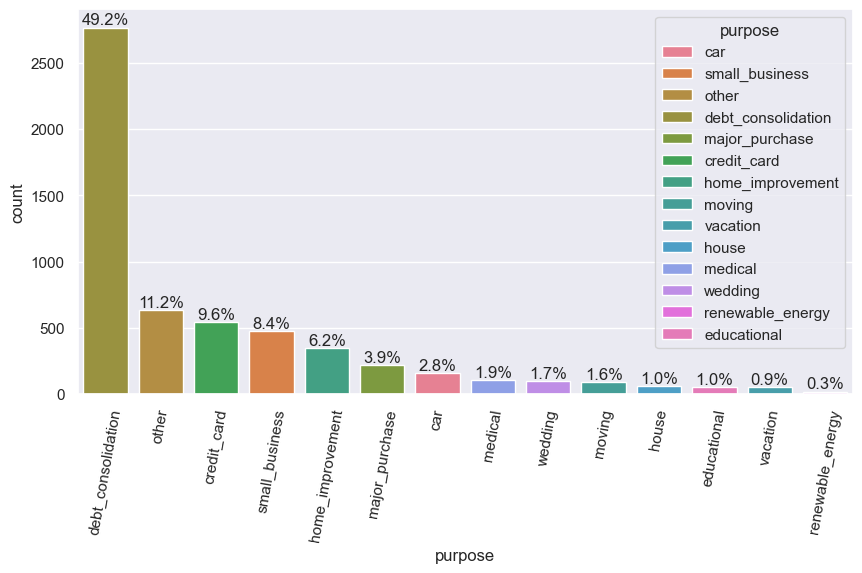

In [41]:
# Purpose - Bivariate Analysis (Purpose vs Loan Status)

default_loan_purpose_order = df1[df1.loan_status == "Charged Off"].purpose.value_counts().index
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data=df1[df1.loan_status == "Charged Off"], x="purpose", hue="purpose", legend="full", ax=ax, order=default_loan_purpose_order)
ax.tick_params(axis='x', rotation=80)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x/len(df1[df1.loan_status == "Charged Off"])*100:0.1f}%')
plt.show()
# Even in defaulted loans, debt consolidation factor to almost 50% of the cases

In [42]:
# Calculate the percentage of default loans for each purpose
purpose_df=pd.DataFrame(data=round((100*df1[df1.loan_status == "Charged Off"].purpose.value_counts())/df1.purpose.value_counts(),2))
purpose_df.rename(columns={'purpose':'count'},inplace=True)
purpose_df.sort_values(by='count',ascending=False,inplace=True)

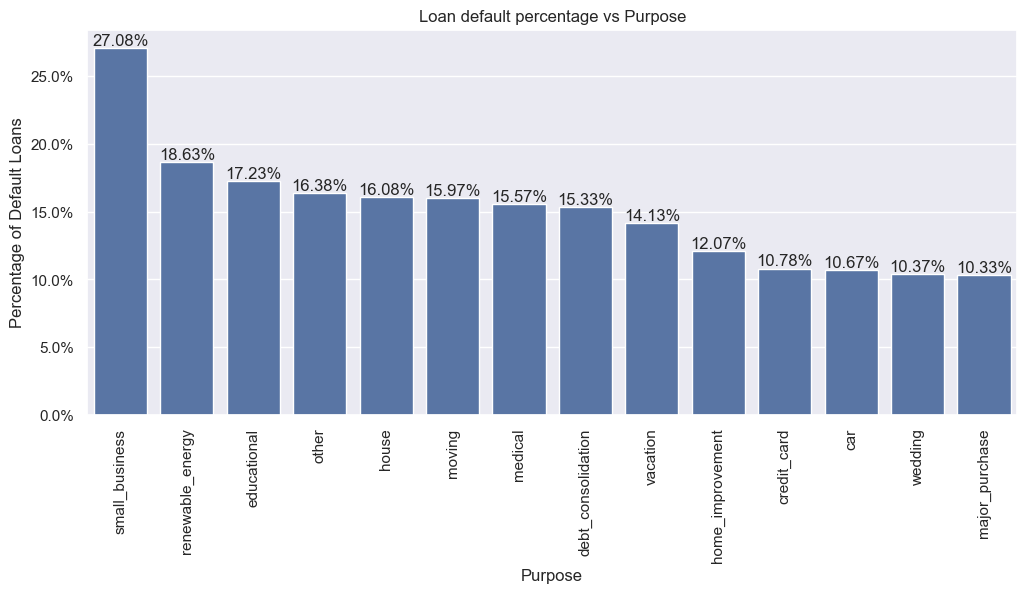

In [43]:
plt.figure(figsize=(12,5))
ax=sns.barplot(x=purpose_df.index,y='count',data=purpose_df)
ax.set(xlabel='Purpose', ylabel='Percentage of Default Loans',title='Loan default percentage vs Purpose')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=90)
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{x}%')
plt.show()

# Small business has significantly higher default rate (25%)

#### Observation - Debt consolidation shared the major proportion of overall loans and also in defaulted loans. But small business has higher default rate (27%)

In [44]:
# title
# df1.title.value_counts()

# Since we have purpose column, we can drop this column
df1 = df1.drop(columns=["title"], axis=1)

In [45]:
# issue_d

df1.issue_d.describe()

count      38577
unique        55
top       Nov-11
freq        2062
Name: issue_d, dtype: object

In [46]:
# We need to convert this into datetime object

df1.issue_d = pd.to_datetime(df1.issue_d, format="%b-%y")

In [47]:
# derived year and month fields
df1["issue_d_year"] = df1.issue_d.dt.year
df1["issue_d_month"] = df1.issue_d.dt.month

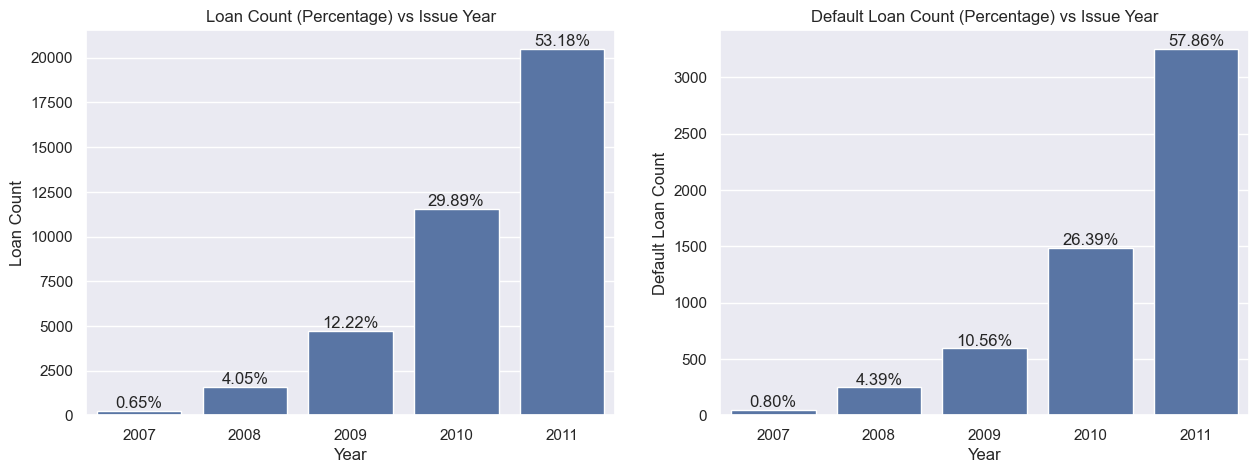

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data=df1, x="issue_d_year", ax=axs[0], legend="full")
axs[0].set(xlabel='Year', ylabel='Loan Count',title='Loan Count (Percentage) vs Issue Year')
axs[0].tick_params(axis='x')
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'{x/len(df1)*100:0.2f}%')

sns.countplot(data=df1[df1.loan_status=="Charged Off"], x="issue_d_year", ax=axs[1], legend="full")
axs[1].set(xlabel='Year', ylabel='Default Loan Count',title='Default Loan Count (Percentage) vs Issue Year')
axs[1].tick_params(axis='x')
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'{x/len(df1[df1.loan_status=="Charged Off"])*100:0.2f}%')

# The number of loans processed and number of loans being defaulted is increasing YoY.
# The rate of increase looks geometric in nature

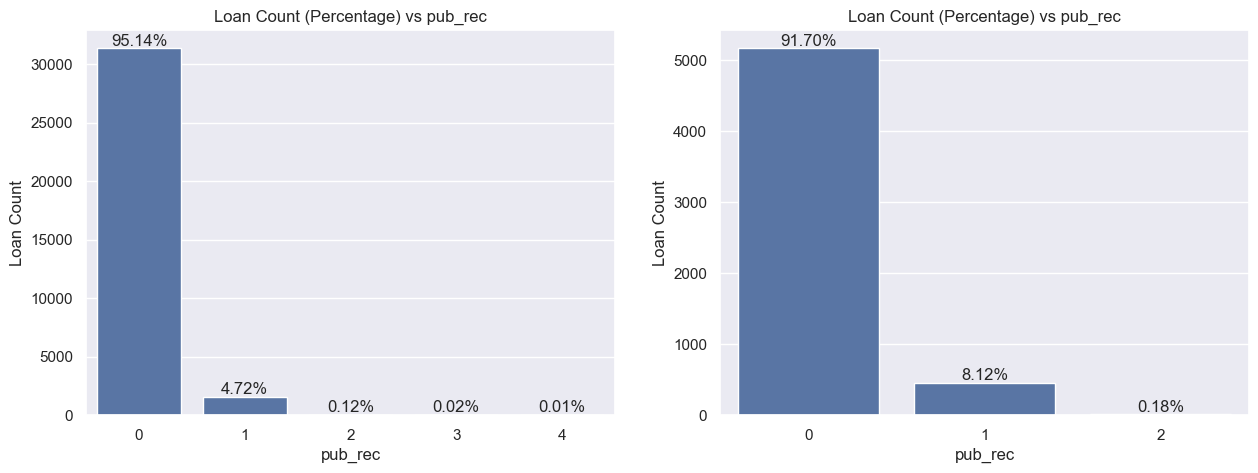

In [49]:
# pub_rec

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data=df1[df1.loan_status=="Fully Paid"], x="pub_rec", ax=axs[0], legend="full")
axs[0].set(xlabel='pub_rec', ylabel='Loan Count',title='Loan Count (Percentage) vs pub_rec')
axs[0].tick_params(axis='x')
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'{x/len(df1[df1.loan_status=="Fully Paid"])*100:0.2f}%')

sns.countplot(data=df1[df1.loan_status=="Charged Off"], x="pub_rec", ax=axs[1], legend="full")
axs[1].set(xlabel='pub_rec', ylabel='Loan Count',title='Loan Count (Percentage) vs pub_rec')
axs[1].tick_params(axis='x')
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'{x/len(df1[df1.loan_status=="Charged Off"])*100:0.2f}%')

# more than 90% of the loans have the value as 0.
# There is higher rate of defaults when the number of pub_rec is '1'

## Numeric Variables

In [50]:
# Following are the numeric columns

numeric_cols = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "annual_inc", "out_prncp", "revol_bal", "revol_util", "out_prncp_inv", "total_pymnt",
               "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", 
               "last_pymnt_amnt"]

In [51]:
# Sanity Check

# Check for nan values
print(f"NaN in numeric_cols\n{df1[numeric_cols].isna().sum()}\n\n")

# Check object types
print(f"dtypes of numeric_cols\n{df1[numeric_cols].dtypes}\n\n")

# All columns look good.
# NaN values in revol_util will be analysed later

NaN in numeric_cols
loan_amnt                   0
funded_amnt                 0
funded_amnt_inv             0
int_rate                    0
installment                 0
annual_inc                  0
out_prncp                   0
revol_bal                   0
revol_util                 50
out_prncp_inv               0
total_pymnt                 0
total_pymnt_inv             0
total_rec_prncp             0
total_rec_int               0
total_rec_late_fee          0
recoveries                  0
collection_recovery_fee     0
last_pymnt_amnt             0
dtype: int64


dtypes of numeric_cols
loan_amnt                    int64
funded_amnt                  int64
funded_amnt_inv            float64
int_rate                   float64
installment                float64
annual_inc                 float64
out_prncp                  float64
revol_bal                    int64
revol_util                 float64
out_prncp_inv              float64
total_pymnt                float64
total_pymnt_inv  

<Axes: xlabel='funded_amnt_inv'>

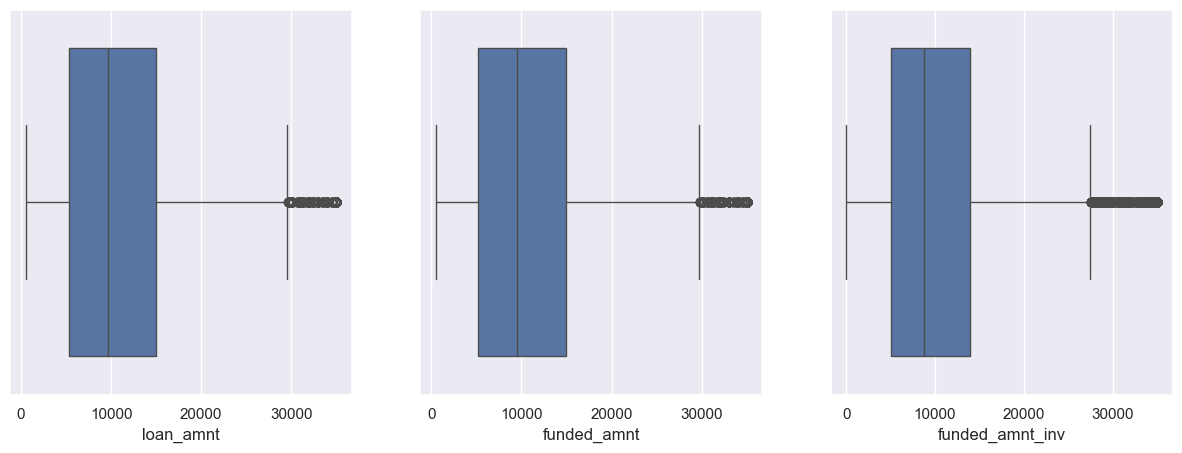

In [52]:
# Loan Amount / Funded Amount / Funded Amount Inv
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

sns.boxplot(data=df1, x="loan_amnt", ax=axs[0])
sns.boxplot(data=df1, x="funded_amnt", ax=axs[1])
sns.boxplot(data=df1, x="funded_amnt_inv", ax=axs[2])

# Since the loan_amnt, funded_amnt, funded_amnt_inv looks all similar.
# We can just rely on loan_amnt for further analysis.

In [53]:
df1.loan_amnt.describe()

# Majority of loans range between 5k to 15k
# Average loan amount is around 11k

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [54]:
# Create a derived bucket column to perform univariate and bivariate analysis.

df1["loan_amnt_buckets"] = pd.cut(
    df1.loan_amnt, 
    bins=[0,5000,10000,15000,20000,25000,30000,35000], labels=["0-5k", "5-10k", "10-15k", "15-20k", "20-25k", "25-30k", "30-35k"]
)

<Axes: title={'center': 'Charged Off Loans'}, xlabel='loan_amnt_buckets', ylabel='count'>

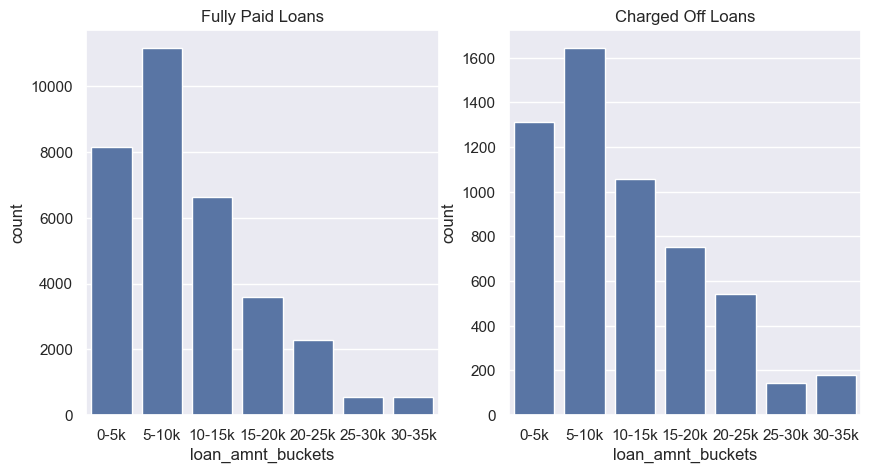

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].set_title("Fully Paid Loans")
axs[1].set_title("Charged Off Loans")
sns.countplot(data=df1[df1.loan_status == "Fully Paid"], x="loan_amnt_buckets", ax=axs[0])
sns.countplot(data=df1[df1.loan_status == "Charged Off"], x="loan_amnt_buckets", ax=axs[1])

In [56]:
#calculate the percentage of loan defaults vs loan_amnt_buckets
loan_amnt_bucket_df=pd.DataFrame(data=round((100*df1[df1.loan_status == "Charged Off"].loan_amnt_buckets.value_counts())/df1.loan_amnt_buckets.value_counts(),2))
loan_amnt_bucket_df.rename(columns={'grade':'count'},inplace=True)

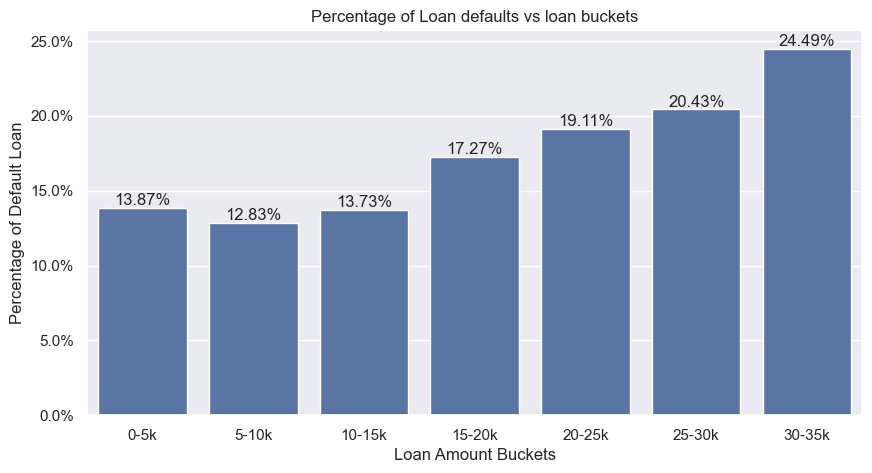

In [57]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x=loan_amnt_bucket_df.index,y='count',data=loan_amnt_bucket_df)
ax.set(xlabel='Loan Amount Buckets', ylabel='Percentage of Default Loan',title='Percentage of Loan defaults vs loan buckets')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for c in ax.containers:
    ax.bar_label(c, fmt= lambda x: f"{x}%")
plt.show()

#### Observation - The default rate increases with increase in loan amount (especially after 15k)

In [58]:
# Annual Income

df1.annual_inc.describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [59]:
# clearly the max value is way off compared to Q3 quantile value.

# Need outlier treatment in this case
df1.annual_inc.quantile([0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.90, 0.95, 0.96, 0.97,0.98, 0.99])

0.10     30000.00
0.20     37196.16
0.30     44500.00
0.40     50004.00
0.50     58868.00
0.60     65004.00
0.70     75000.00
0.80     90000.00
0.90    115000.00
0.95    140004.00
0.96    150000.00
0.97    165000.00
0.98    187000.00
0.99    234144.00
Name: annual_inc, dtype: float64

In [60]:
# There is significant jump after 0.98. Hence removing data that are greater than 0.98 quantile value
df1 = df1[df1.annual_inc <= df1.annual_inc.quantile(0.98)]
df1.shape

(37807, 45)

[Text(0.5, 0, 'Annual Income'),
 Text(0, 0.5, 'Loan Count'),
 Text(0.5, 1.0, 'Default Loan Count vs Annual Income')]

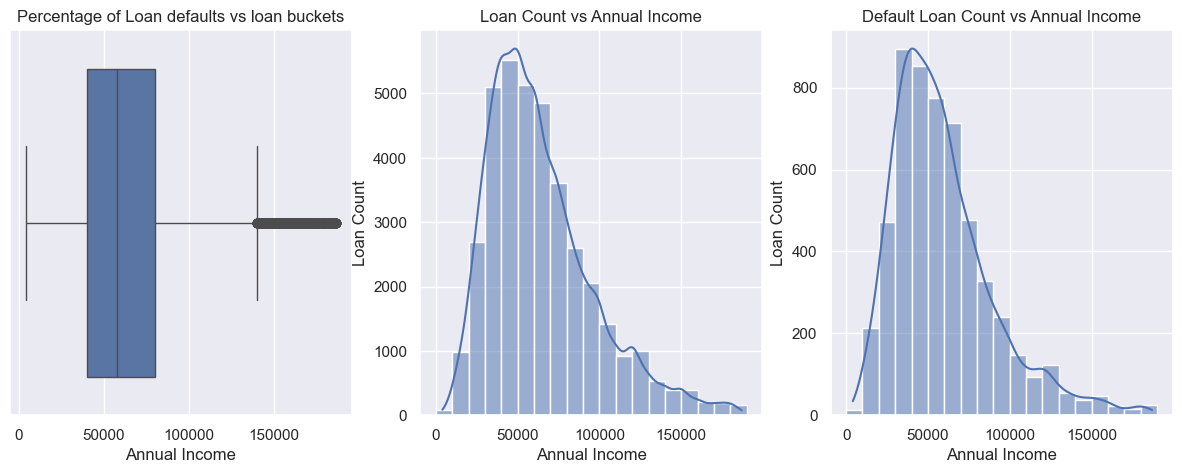

In [61]:
# Post removal of outlier
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.boxplot(data=df1, x="annual_inc", ax=axs[0])
axs[0].set(xlabel='Annual Income',title='Percentage of Loan defaults vs loan buckets')
sns.histplot(data=df1, binwidth=10000, binrange=(0,190000), x="annual_inc", kde=True, ax=axs[1])
axs[1].set(xlabel='Annual Income', ylabel='Loan Count',title='Loan Count vs Annual Income')
sns.histplot(data=df1[df1.loan_status=="Charged Off"], binwidth=10000, binrange=(0,190000), x="annual_inc", kde=True, ax=axs[2])
axs[2].set(xlabel='Annual Income', ylabel='Loan Count',title='Default Loan Count vs Annual Income')

# Most borrower's income are in the range 40000 to 80000
# Lets create annual income bucket for further analysis

In [62]:
df1["annual_inc_buckets"] = pd.cut(
    df1.annual_inc, 
    bins=[0, 50000, 100000, 150000, 200000],
    labels=["0-50k", "50-100k", "100-150k", "150-200k"]
)

In [63]:
annual_inc_buckets_df=pd.DataFrame(data=round((100*df1[df1.loan_status == "Charged Off"].annual_inc_buckets.value_counts())/df1.annual_inc_buckets.value_counts(),2))
annual_inc_buckets_df.rename(columns={'grade':'count'},inplace=True)
annual_inc_buckets_df.sort_values(by='count',ascending=False,inplace=True)

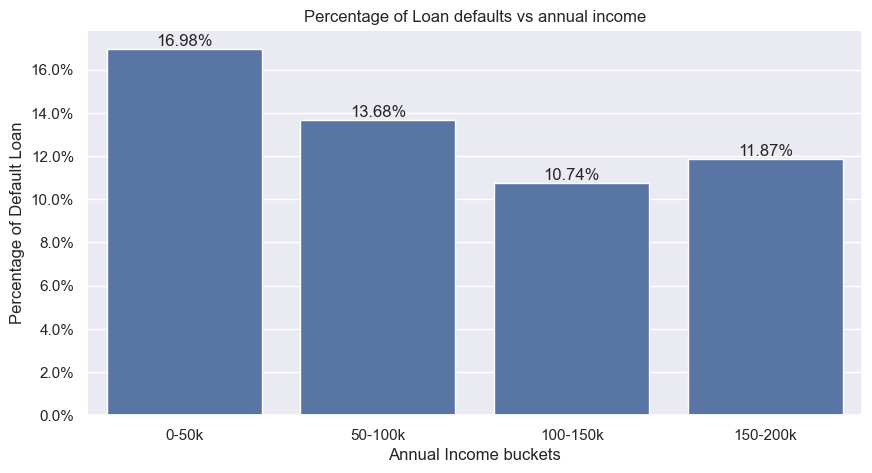

In [64]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x=annual_inc_buckets_df.index,y='count',data=annual_inc_buckets_df)
ax.set(xlabel='Annual Income buckets', ylabel='Percentage of Default Loan',title='Percentage of Loan defaults vs annual income')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for c in ax.containers:
    ax.bar_label(c, fmt= lambda x: f"{x}%")
plt.show()

#### Observation - Lesser annual income (i.e less than 50k) has higher default rate.

In [65]:
# dti

df1.dti.describe()

count    37807.000000
mean        13.367274
std          6.657441
min          0.000000
25%          8.250000
50%         13.480000
75%         18.630000
max         29.990000
Name: dti, dtype: float64

<Axes: xlabel='dti', ylabel='Count'>

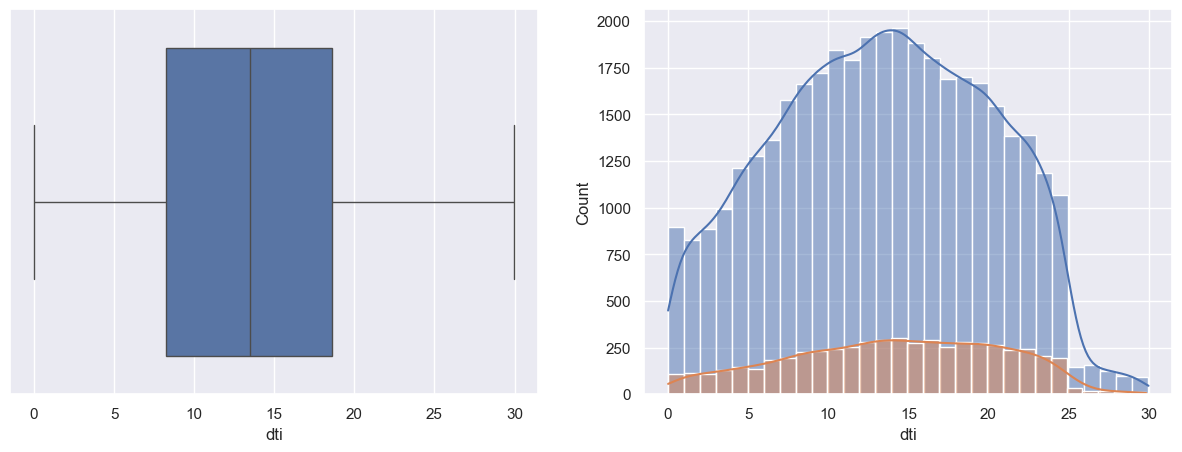

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.boxplot(data=df1, x="dti", ax=axs[0])
sns.histplot(data=df1, binwidth=1, x="dti", kde=True, ax=axs[1])
sns.histplot(data=df1[df1.loan_status=="Charged Off"], binwidth=1, x="dti", kde=True, ax=axs[1])

# The IQR range is between 8 - 18
# There is sudden dip in number of loan profiles after dti=25 but it is difficult to understand the reason for that.

[Text(0.5, 0, 'Revol bal'), Text(0.5, 1.0, 'Default Loans')]

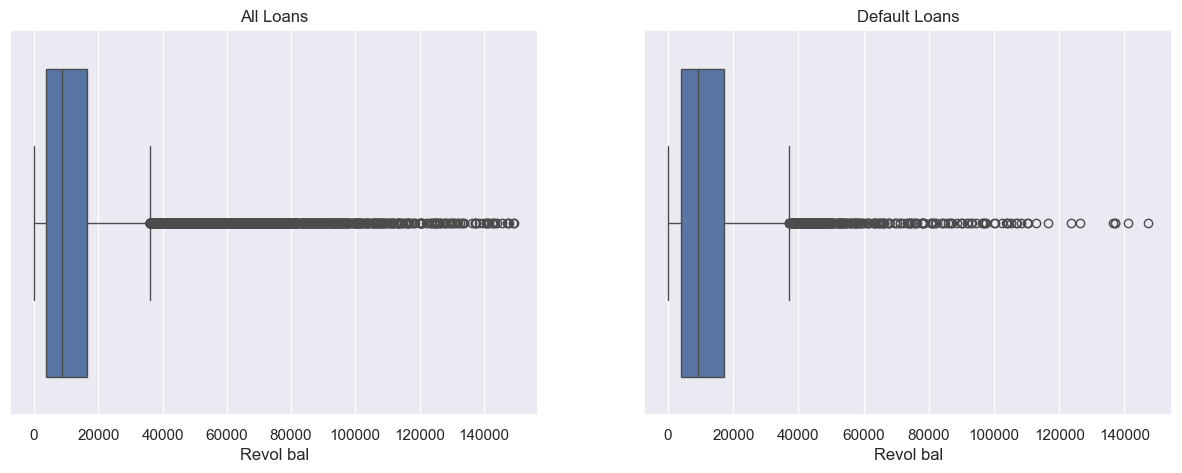

In [67]:
# revol_bal

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.boxplot(data=df1, x="revol_bal", ax=axs[0])
axs[0].set(xlabel='Revol bal',title='All Loans')
sns.boxplot(data=df1[df1.loan_status=="Charged Off"], x="revol_bal", ax=axs[1])
axs[1].set(xlabel='Revol bal', title='Default Loans')

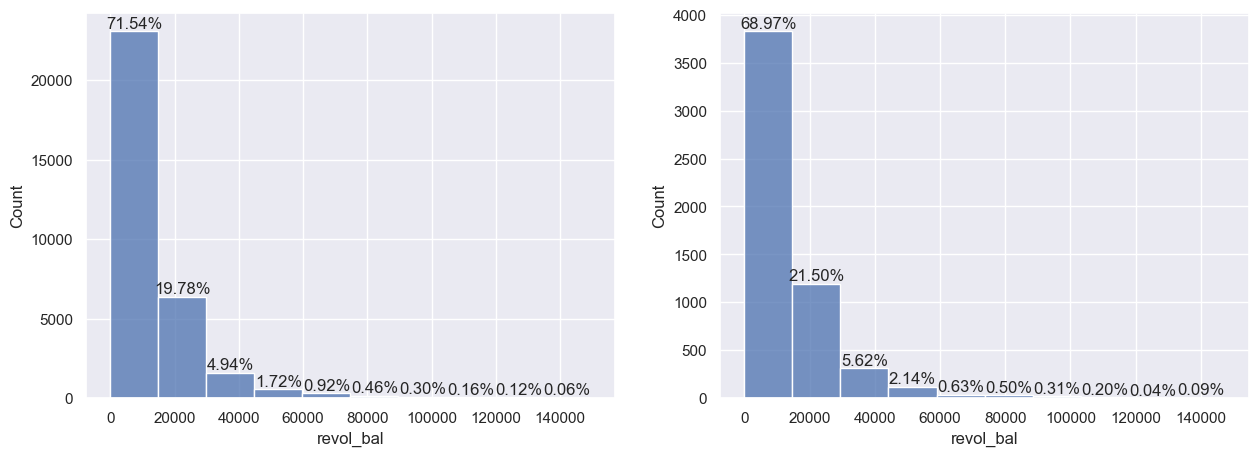

In [68]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.histplot(data=df1[df1.loan_status=="Fully Paid"], x="revol_bal", ax=axs[0], legend="full", bins=10)
axs[0].tick_params(axis='x')
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'{x/len(df1[df1.loan_status=="Fully Paid"])*100:0.2f}%')

sns.histplot(data=df1[df1.loan_status=="Charged Off"], x="revol_bal", ax=axs[1], legend="full", bins=10)
axs[1].tick_params(axis='x')
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'{x/len(df1[df1.loan_status=="Charged Off"])*100:0.2f}%')


# Clearly we can see that revol_bal follows similar pattern in both "Fully Paid" and "Charged Off" category.
# There are outliers which has potential to skew the metrics. But will decide on this later during bivariate analysis.

In [69]:
# revol_util

df1.revol_util.describe()

count    37758.000000
mean        48.683560
std         28.319586
min          0.000000
25%         25.200000
50%         49.100000
75%         72.200000
max         99.900000
Name: revol_util, dtype: float64

In [70]:
df1.revol_util[df1.loan_status == "Charged Off"].describe()

count    5533.000000
mean       55.490278
std        27.909876
min         0.000000
25%        34.300000
50%        58.200000
75%        79.000000
max        99.900000
Name: revol_util, dtype: float64

In [71]:
# Clearly the mean and median values are 7%-10% higher in the default loan profiles.

<Axes: xlabel='revol_util', ylabel='Count'>

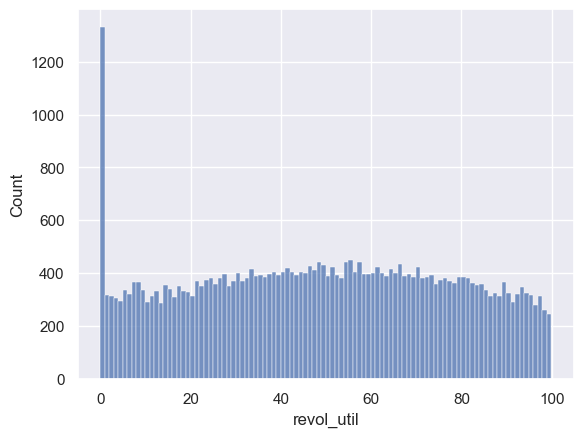

In [72]:
# We have seen that the revol_util has null values.
# There are 49 null values in the column.

sns.histplot(data = df1, x="revol_util", bins=100)

In [73]:
# Since there are small number of null values, and except for the 0 value, everything else is equally distributed, 
# We can replace the null with any of mean/median/mode without impacting the analysis
# Currently choosing mode to replace null value

df1.revol_util.fillna(df1.revol_util.mode()[0], inplace=True)

/var/folders/xq/qn7mv_yx6sg_np6wfrwbplgm0000gn/T/ipykernel_10402/1338949340.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1.revol_util.fillna(df1.revol_util.mode()[0], inplace=True)


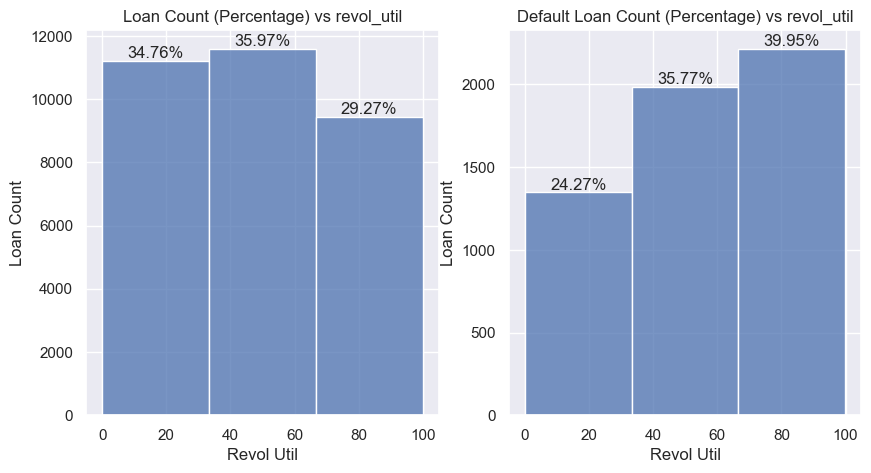

In [74]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.histplot(data=df1[df1.loan_status=="Fully Paid"], x="revol_util", ax=axs[0], legend="full", bins=3)
axs[0].set(xlabel='Revol Util', ylabel='Loan Count',title='Loan Count (Percentage) vs revol_util')
axs[0].tick_params(axis='x')
for c in axs[0].containers:
    axs[0].bar_label(c, fmt=lambda x: f'{x/len(df1[df1.loan_status=="Fully Paid"])*100:0.2f}%')

sns.histplot(data=df1[df1.loan_status=="Charged Off"], x="revol_util", ax=axs[1], legend="full", bins=3)
axs[1].set(xlabel='Revol Util', ylabel='Loan Count',title='Default Loan Count (Percentage) vs revol_util')
axs[1].tick_params(axis='x')
for c in axs[1].containers:
    axs[1].bar_label(c, fmt=lambda x: f'{x/len(df1[df1.loan_status=="Charged Off"])*100:0.2f}%')

#### Observation - Higher the percentage of revol_util, higher the chances of loan default

## Other Bivariate Analysis

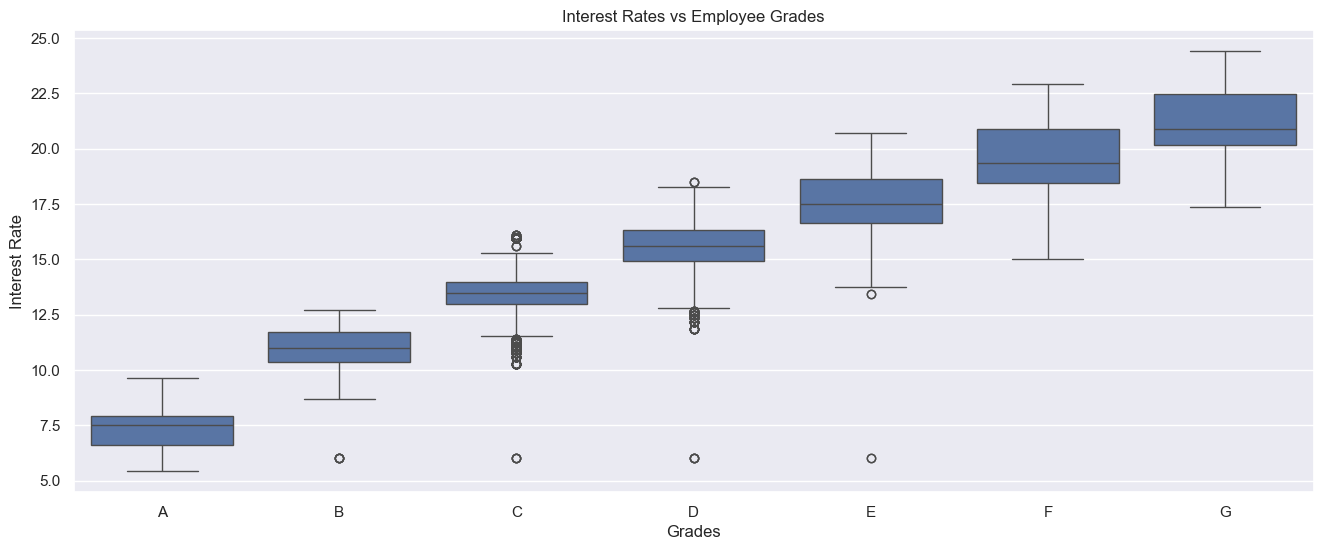

In [75]:
# Grade vs Interest Rate

int_rate_order = df1.groupby(by="grade")["int_rate"].mean().index
plt.figure(figsize=(16,6))
ax=sns.boxplot(x='grade',y='int_rate',data=df1,order=int_rate_order)
ax.set(xlabel='Grades', ylabel='Interest Rate',title='Interest Rates vs Employee Grades')
plt.show()

In [76]:
# We had seen earlier that higher interest rate has higher default rate and
# the default rate increases from grade A to grade G.
# The above visualisation validates it.

#### Observations from analysis

* __Loan Amount__:
    - Maximum number of applications have loan amount between 5000 to 15000
    - We can see that as the loan amount increases beyond 15K, the default rate also increases significantly.
* __Interest rate__: Both Fully Paid and Charged Off Loans have peaks at 11%-14%. 
        But higher interest rates leads to higher rate default.
* __Purpose__:
    - Debt consolidation has higher loan applications and also default rate. 
    - Small_business has highest default rate in each bucket. Nearly 1/4th of the applications have defaulted in this category
* __Term__: The probability of default is double where the term is 60 months (22%) compared to loans where the term is 36 months.
* __Annual Income__: Most borrowers income range between 40000 to 80000.
    - Default rate is higher in lower income bucket i.e between 0-50k
* __Grades__: The default rate increase from grade A to grade G
* __Sub Grades__: In general all sub grades of A has lesser chances of default
    - The proportion of sub grades D,E,F is higher in default loan profiles compared to those in Fully Paid
* __Pub rec__: There is higher rate of defaults when the number of pub_rec is '1'
* __Revol_util__: Default loans have higher revol_util rates in general. Nearly 60% of default loans have more than 50% revol_util
* __issue_d__: The number for loans are increasing every year and it is maximum during 2011. Correspondingly, the default rate is also increasing.

#### Recommendation to Business

* Tighten evaluation for all applications where loan amount in greater than 15k.
* If the credit score is deriving higher interest rate, then the probablity of default is also higher. Hence the company should have adequate
buffer to handle such events.
* Avoid lending money for borrowers having very less annual income. Target people who have more than 40k in general.
* Grade A, B category borrowers are less risky. Hence target more of those.
* If revol_util is greater than 50%, then tighten evaluation process
* Preference should be given to 36months term instead of 60 months
* Tighten lending process for small business